# TF-IDF with N-gram Tokenization and Model Training

This notebook demonstrates:
1. **Optimized Manual TF-IDF Implementation** with N-gram tokenization (from scratch)
2. **Sparse matrix support** for memory efficiency (scipy.sparse)
3. Adjustable n-gram range parameter (default: unigrams + bigrams)
4. **Vocabulary filtering** (top 10K n-grams, min_df=3, max_df=80%)
5. **Manual Naive Bayes** implementation from scratch
6. Comparison with unigram-only approach
7. Model evaluation with comprehensive metrics

**Key Enhancements:**
- ✅ N-gram tokenization captures word sequences (e.g., "இலங்கை அரசு")
- ✅ Vocabulary filtering (top 10K n-grams, min_df=3, max_df=80%)
- ✅ Sparse matrices (float32) for memory efficiency
- ✅ Manual Naive Bayes implementation

**Dataset:** Tamil news articles with categories and processed text


## 1. Import Required Libraries

In [11]:
import pandas as pd
import numpy as np
import math
import pickle
import os
from collections import Counter, defaultdict
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from scipy.sparse import lil_matrix, csr_matrix
import time
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print("Libraries imported successfully!")
print("N-gram tokenization enabled ✓")
print("Sparse matrix support enabled ✓")


Libraries imported successfully!
N-gram tokenization enabled ✓
Sparse matrix support enabled ✓


## 2. Load the Cleaned Data

In [12]:
# Load the processed data from previous notebook
df = pd.read_csv('output/processed_data.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (18447, 5)

Columns: ['category', 'processed_title', 'cleaned_title', 'tokenized_title', 'title']

First few rows:


,category,processed_title,cleaned_title,tokenized_title,title
0,tamilnadu,மேகதாது விவகாரம் தமிழக கர்நாடகா முதலமைச்சர் நிதின் கட்கரி கடிதம்,மேகதாது விவகாரம் தமிழக கர்நாடகா முதலமைச்சர்களுக்கு நிதின் கட்கரி கடிதம்,மேகதாது விவகாரம் தமிழக கர்நாடகா முதலமைச்சர்களுக்கு நிதின் கட்கரி கடிதம்,"மேகதாது விவகாரம்: தமிழக, கர்நாடகா முதலமைச்சர்களுக்கு நிதின் கட்கரி கடிதம்"
1,sports,பந்துவீச்சாளர் ஐபிஎல் விளையாடலாமா எதிரெதிர் கருத்தில் தோனி கும்பளே,பந்துவீச்சாளர்கள் ஐபிஎல் விளையாடலாமா எதிரெதிர் கருத்தில் தோனி கும்பளே,பந்துவீச்சாளர்கள் ஐபிஎல் விளையாடலாமா எதிரெதிர் கருத்தில் தோனி கும்பளே,பந்துவீச்சாளர்கள் ஐபிஎல் விளையாடலாமா? - எதிரெதிர் கருத்தில் தோனி-கும்பளே
2,tamilnadu,கனமழை எச்சரிக்கை நாளை பள்ளி கல்லூரி விடுமுறை எங்கெல்லாம் தெரியுமா,கனமழை எச்சரிக்கை நாளை பள்ளி கல்லூரிகளுக்கு விடுமுறை எங்கெல்லாம் தெரியுமா,கனமழை எச்சரிக்கை நாளை பள்ளி கல்லூரிகளுக்கு விடுமுறை எங்கெல்லாம் தெரியுமா,"கனமழை எச்சரிக்கை | நாளை பள்ளி, கல்லூரிகளுக்கு விடுமுறை.. எங்கெல்லாம் தெரியுமா?"
3,tamilnadu,தவெகவை ஆண்டவனாலும் காப்பாற்ற முடியாது விஜய் ஆர்பி உதயகுமார் அட்வைஸ்,தவெகவை ஆண்டவனாலும் காப்பாற்ற முடியாது விஜய்க்கு ஆர்பி உதயகுமார் அட்வைஸ்,தவெகவை ஆண்டவனாலும் காப்பாற்ற முடியாது விஜய்க்கு ஆர்பி உதயகுமார் அட்வைஸ்,தவெகவை ஆண்டவனாலும் காப்பாற்ற முடியாது - விஜய்க்கு ஆர்பி உதயகுமார் அட்வைஸ்
4,tamilnadu,ஆழ் காற்றழு தாழ்வுப்பகுதி எதிரொலி மாவட்டங் அலர்ட்,ஆழ்ந்த காற்றழுத்த தாழ்வுப்பகுதி எதிரொலி மாவட்டங்களுக்கு அலர்ட்,ஆழ்ந்த காற்றழுத்த தாழ்வுப்பகுதி எதிரொலி மாவட்டங்களுக்கு அலர்ட்,ஆழ்ந்த காற்றழுத்த தாழ்வுப்பகுதி எதிரொலி.. 8 மாவட்டங்களுக்கு RED அலர்ட்..


In [13]:
# Check data distribution
print("Category distribution:")
print(df['category'].value_counts())
print(f"\nTotal samples: {len(df)}")
print(f"Missing values:\n{df.isnull().sum()}")

Category distribution:
category
india                                     2191
world                                     1893
cinema                                    1811
sports                                    1748
crime                                     1627
tamilnadu                                 1589
business                                  1304
trending                                  1271
technology                                1225
features                                  1196
health                                     841
environment                                639
agriculture                                613
spiritual                                  245
lifestyle                                  103
motor                                       45
coronavirus                                 38
ampstories                                  30
women                                       20
employment-news-in-tamil-latest-update      18
Name: count, dtype: int64

T

## 3. Prepare Text Data for TF-IDF

We'll use the `cleaned_title` column which contains preprocessed Tamil text.

In [14]:
# Select the text column and target variable
documents = df['cleaned_title'].fillna('').tolist()
labels = df['category'].tolist()

print(f"Total documents: {len(documents)}")
print(f"Total labels: {len(labels)}")
print(f"\nSample document: {documents[0]}")
print(f"Sample label: {labels[0]}")

Total documents: 18447
Total labels: 18447

Sample document: மேகதாது விவகாரம் தமிழக கர்நாடகா முதலமைச்சர்களுக்கு நிதின் கட்கரி கடிதம்
Sample label: tamilnadu


## 4. TF-IDF Implementation from Scratch with N-grams

### Step 1: N-gram Tokenization

**Key Enhancement:** Instead of splitting only into single words (unigrams), we now generate word n-grams based on `ngram_range`.

- **Unigrams (1-gram):** ["இலங்கை", "அரசு", "தீர்மானம்"]
- **Bigrams (2-gram):** ["இலங்கை அரசு", "அரசு தீர்மானம்"]
- **ngram_range=(1,2):** Both unigrams and bigrams combined

This captures context and word sequences as features.

In [15]:
def generate_ngrams(tokens, ngram_range=(1, 2)):
    """
    Generate n-grams from a list of tokens.
    
    Args:
        tokens: List of words (tokens)
        ngram_range: Tuple (min_n, max_n) specifying the range of n-grams
    
    Returns:
        List of n-gram strings
    """
    ngrams = []
    min_n, max_n = ngram_range
    
    for n in range(min_n, max_n + 1):
        for i in range(len(tokens) - n + 1):
            ngram = ' '.join(tokens[i:i+n])
            ngrams.append(ngram)
    
    return ngrams

def tokenize_with_ngrams(text, ngram_range=(1, 2)):
    """
    Tokenize text and generate n-grams.
    """
    tokens = text.split()
    return generate_ngrams(tokens, ngram_range)

# Example of n-gram tokenization
sample_text = documents[0] if documents[0] else "இலங்கை அரசு தீர்மானம்"
sample_tokens = sample_text.split()

print("Original tokens (unigrams only):")
print(sample_tokens[:10])

print("\nN-grams with ngram_range=(1, 2):")
ngrams_sample = generate_ngrams(sample_tokens, ngram_range=(1, 2))
print(ngrams_sample[:15])

Original tokens (unigrams only):
['மேகதாது', 'விவகாரம்', 'தமிழக', 'கர்நாடகா', 'முதலமைச்சர்களுக்கு', 'நிதின்', 'கட்கரி', 'கடிதம்']

N-grams with ngram_range=(1, 2):
['மேகதாது', 'விவகாரம்', 'தமிழக', 'கர்நாடகா', 'முதலமைச்சர்களுக்கு', 'நிதின்', 'கட்கரி', 'கடிதம்', 'மேகதாது விவகாரம்', 'விவகாரம் தமிழக', 'தமிழக கர்நாடகா', 'கர்நாடகா முதலமைச்சர்களுக்கு', 'முதலமைச்சர்களுக்கு நிதின்', 'நிதின் கட்கரி', 'கட்கரி கடிதம்']


In [16]:
# Configurable n-gram range parameter
NGRAM_RANGE = (1, 2)  # Default: unigrams + bigrams

# Apply n-gram tokenization to all documents
tokenized_docs = [tokenize_with_ngrams(doc, ngram_range=NGRAM_RANGE) for doc in documents]
print(f"Tokenized {len(tokenized_docs)} documents with ngram_range={NGRAM_RANGE}")
print(f"Sample tokenized document length: {len(tokenized_docs[0])} n-grams")

Tokenized 18447 documents with ngram_range=(1, 2)
Sample tokenized document length: 15 n-grams


### Step 2: Build Optimized Vocabulary with N-grams

Create a vocabulary with filtering:
1. Compute global n-gram frequencies across all documents
2. Keep only top 10,000 most frequent n-grams
3. Remove n-grams in < 3 documents (too rare)
4. Remove n-grams in > 80% of documents (too common)


In [ ]:
# Configuration
MAX_FEATURES = 10000  # Maximum vocabulary size
MIN_DF = 3  # Minimum document frequency
MAX_DF_RATIO = 0.8  # Maximum document frequency ratio

print("Building optimized n-gram vocabulary...")

# Step 1: Compute global n-gram frequencies
ngram_freq = Counter()
for doc in tokenized_docs:
    ngram_freq.update(doc)

print(f"Total unique n-grams before filtering: {len(ngram_freq)}")

# Step 2: Compute document frequency for each n-gram
ngram_df = {}
for ngram in ngram_freq.keys():
    ngram_df[ngram] = sum(1 for doc in tokenized_docs if ngram in doc)

# Step 3: Filter by document frequency
n_docs = len(tokenized_docs)
max_df = int(MAX_DF_RATIO * n_docs)

filtered_ngrams = {
    ngram for ngram, df in ngram_df.items()
    if MIN_DF <= df <= max_df
}

print(f"N-grams after DF filtering: {len(filtered_ngrams)}")

# Step 4: Keep only top MAX_FEATURES most frequent n-grams
if len(filtered_ngrams) > MAX_FEATURES:
    # Sort by frequency and take top MAX_FEATURES
    top_ngrams = sorted(
        [(ngram, ngram_freq[ngram]) for ngram in filtered_ngrams],
        key=lambda x: x[1],
        reverse=True
    )[:MAX_FEATURES]
    vocabulary = sorted([ngram for ngram, _ in top_ngrams])
else:
    vocabulary = sorted(list(filtered_ngrams))

word2idx = {word: idx for idx, word in enumerate(vocabulary)}

print(f"\n{'='*60}")
print(f"Optimized N-gram Vocabulary Statistics:")
print(f"  N-gram range: {NGRAM_RANGE}")
print(f"  Final vocabulary size: {len(vocabulary):,} unique n-grams")
print(f"  Max features limit: {MAX_FEATURES:,}")
print(f"  Min document frequency: {MIN_DF}")
print(f"  Max document frequency: {max_df} ({MAX_DF_RATIO*100:.0f}%)")
print(f"  Reduction: {len(ngram_freq) - len(vocabulary):,} n-grams removed")
print(f"{'='*60}")

print(f"\nSample vocabulary entries:")
print(vocabulary[:10])


Building optimized n-gram vocabulary...
Total unique n-grams before filtering: 144438


### Step 3: Compute Term Frequency (TF) for N-grams

**Term Frequency (TF)** measures how frequently an n-gram appears in a document.

Formula: `TF(t, d) = (Number of times n-gram t appears in document d) / (Total number of n-grams in document d)`

In [18]:
def compute_tf(tokenized_doc, vocabulary_set):
    """Compute term frequency for n-grams: TF(t) = count(t) / total_ngrams
    Only considers n-grams in the filtered vocabulary."""
    tf_dict = {}
    doc_length = len(tokenized_doc)
    if doc_length == 0:
        return tf_dict
    
    term_counts = Counter(tokenized_doc)
    # Only keep n-grams that are in vocabulary
    for term, count in term_counts.items():
        if term in vocabulary_set:
            tf_dict[term] = count / doc_length
    return tf_dict

vocabulary_set = set(vocabulary)
tf_docs = [compute_tf(doc, vocabulary_set) for doc in tokenized_docs]
print("Term Frequency computed for n-grams (using filtered vocabulary)")
print(f"Sample TF dict entries: {list(tf_docs[0].items())[:5]}")


Term Frequency computed for n-grams (using filtered vocabulary)
Sample TF dict entries: [('விவகாரம்', 0.06666666666666667), ('தமிழக', 0.06666666666666667), ('கர்நாடகா', 0.06666666666666667), ('நிதின்', 0.06666666666666667), ('கட்கரி', 0.06666666666666667)]


### Step 4: Compute Inverse Document Frequency (IDF) for N-grams

**Inverse Document Frequency (IDF)** measures how important an n-gram is across the entire corpus.

Formula: `IDF(t) = log(Total number of documents / Number of documents containing n-gram t)`

In [19]:
def compute_idf(tokenized_docs, vocabulary):
    """Compute IDF for n-grams: IDF(t) = log(N / df(t))"""
    N = len(tokenized_docs)
    idf_dict = {}
    for word in vocabulary:
        doc_count = sum(1 for doc in tokenized_docs if word in doc)
        idf_dict[word] = math.log(N / (doc_count + 1))
    return idf_dict

print("Computing IDF for n-grams...")
idf_dict = compute_idf(tokenized_docs, vocabulary)
print(f"IDF computed for {len(idf_dict)} n-grams")
print(f"Sample IDF values: {list(idf_dict.items())[:5]}")

Computing IDF for n-grams...
IDF computed for 10000 n-grams
Sample IDF values: [('ஃபண்ட்', 8.213219122187478), ('ஃபர்ஸ்ட்', 7.520071941627534), ('ஃபர்ஸ்ட் லுக்', 8.030897565393524), ('ஃபாலோ', 8.213219122187478), ('ஃபிளிப்கார்ட்', 8.436362673501689)]
IDF computed for 10000 n-grams
Sample IDF values: [('ஃபண்ட்', 8.213219122187478), ('ஃபர்ஸ்ட்', 7.520071941627534), ('ஃபர்ஸ்ட் லுக்', 8.030897565393524), ('ஃபாலோ', 8.213219122187478), ('ஃபிளிப்கார்ட்', 8.436362673501689)]


### Step 5: Compute TF-IDF Weights for N-grams

**TF-IDF** combines both TF and IDF to get the final weight for each n-gram in each document.

Formula: `TF-IDF(t, d) = TF(t, d) × IDF(t)`

In [20]:
def compute_tfidf(tf_dict, idf_dict):
    """Compute TF-IDF for n-grams: TF-IDF(t, d) = TF(t, d) × IDF(t)"""
    tfidf_dict = {}
    for term, tf_value in tf_dict.items():
        tfidf_dict[term] = tf_value * idf_dict.get(term, 0)
    return tfidf_dict

tfidf_docs = [compute_tfidf(tf, idf_dict) for tf in tf_docs]
print("TF-IDF weights computed for n-grams")

TF-IDF weights computed for n-grams


### Step 6: Create Sparse TF-IDF Matrix with N-grams

Convert the TF-IDF dictionaries into a **sparse matrix** representation:
- Rows represent documents
- Columns represent n-grams in vocabulary
- Values are TF-IDF weights
- Uses `scipy.sparse.lil_matrix` (efficient for construction)
- Converts to CSR format for efficient model training


In [21]:
def create_tfidf_matrix_sparse(tfidf_docs, vocabulary, word2idx):
    """Create sparse TF-IDF matrix: (n_documents, n_vocabulary)
    Uses lil_matrix for efficient construction, then converts to CSR."""
    n_docs = len(tfidf_docs)
    n_vocab = len(vocabulary)
    
    # Use lil_matrix (List of Lists) for efficient construction
    tfidf_matrix = lil_matrix((n_docs, n_vocab), dtype=np.float32)
    
    for doc_idx, tfidf_dict in enumerate(tfidf_docs):
        for term, tfidf_value in tfidf_dict.items():
            if term in word2idx:
                term_idx = word2idx[term]
                tfidf_matrix[doc_idx, term_idx] = tfidf_value
    
    # Convert to CSR (Compressed Sparse Row) for efficient arithmetic operations
    tfidf_matrix_csr = tfidf_matrix.tocsr()
    
    return tfidf_matrix_csr

print("Creating sparse TF-IDF matrix with n-grams...")
print("  Format: scipy.sparse (lil_matrix → csr_matrix)")
print("  Dtype: float32 (memory efficient)")

tfidf_matrix_custom = create_tfidf_matrix_sparse(tfidf_docs, vocabulary, word2idx)

print(f"\n✓ TF-IDF Matrix created: {tfidf_matrix_custom.shape}")
print(f"  Matrix type: {type(tfidf_matrix_custom)}")
print(f"  Matrix format: {tfidf_matrix_custom.format}")
print(f"  Data type: {tfidf_matrix_custom.dtype}")
print(f"  Documents: {tfidf_matrix_custom.shape[0]}")
print(f"  N-gram features: {tfidf_matrix_custom.shape[1]}")


Creating sparse TF-IDF matrix with n-grams...
  Format: scipy.sparse (lil_matrix → csr_matrix)
  Dtype: float32 (memory efficient)

✓ TF-IDF Matrix created: (18447, 10000)
  Matrix type: <class 'scipy.sparse._csr.csr_matrix'>
  Matrix format: csr
  Data type: float32
  Documents: 18447
  N-gram features: 10000


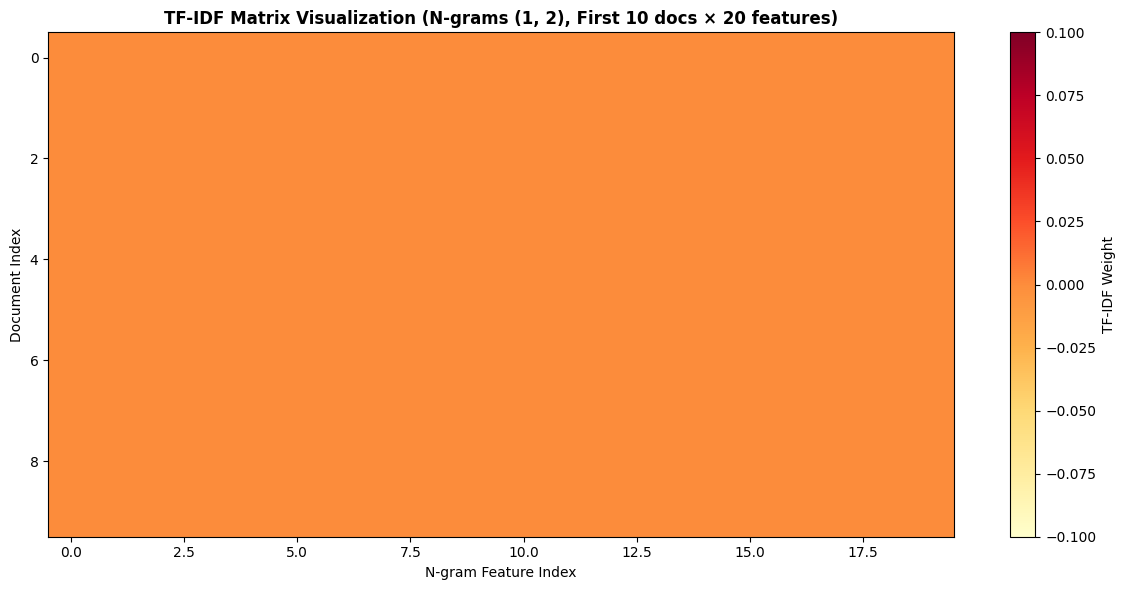

In [22]:
# Visualize a small portion of the matrix (convert to dense for visualization)
try:
    mat = tfidf_matrix_custom
except NameError:
    print("tfidf_matrix_custom not found. Creating TF-IDF matrix from tfidf_docs, vocabulary and word2idx...")
    tfidf_matrix_custom = create_tfidf_matrix_sparse(tfidf_docs, vocabulary, word2idx)
    mat = tfidf_matrix_custom

# For sparse matrices use .toarray() on the small slice, otherwise slice directly
if hasattr(mat, 'toarray'):
    sample_matrix = mat[:10, :20].toarray()
else:
    sample_matrix = mat[:10, :20]

plt.figure(figsize=(12, 6))
plt.imshow(sample_matrix, aspect='auto', cmap='YlOrRd')
plt.colorbar(label='TF-IDF Weight')
plt.xlabel('N-gram Feature Index')
plt.ylabel('Document Index')
plt.title(f'TF-IDF Matrix Visualization (N-grams {NGRAM_RANGE}, First 10 docs × 20 features)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


## 5. TF-IDF Matrix Statistics

In [23]:
# Display TF-IDF matrix statistics (safe for sparse matrices)
print(f"{'='*60}")
print(f"TF-IDF Matrix Statistics (N-grams {NGRAM_RANGE}):")
print(f"{'='*60}")
print(f"  Shape: {tfidf_matrix_custom.shape}")
print(f"  Documents: {tfidf_matrix_custom.shape[0]:,}")
print(f"  N-gram features: {tfidf_matrix_custom.shape[1]:,}")
print(f"  Data type: {tfidf_matrix_custom.dtype}")
print(f"  Matrix format: {tfidf_matrix_custom.format}")

# Compute statistics efficiently for sparse matrices
print(f"\n  Non-zero elements: {tfidf_matrix_custom.nnz:,}")
print(f"  Total elements: {tfidf_matrix_custom.shape[0] * tfidf_matrix_custom.shape[1]:,}")
print(f"  Sparsity: {(1 - tfidf_matrix_custom.nnz / (tfidf_matrix_custom.shape[0] * tfidf_matrix_custom.shape[1])) * 100:.2f}%")

# Statistics on non-zero values only (efficient)
data = tfidf_matrix_custom.data
print(f"\n  Mean (non-zero): {data.mean():.6f}")
print(f"  Max: {data.max():.6f}")
print(f"  Min (non-zero): {data.min():.6f}")
print(f"  Std (non-zero): {data.std():.6f}")

# Memory usage estimate
memory_mb = (tfidf_matrix_custom.data.nbytes + 
             tfidf_matrix_custom.indices.nbytes + 
             tfidf_matrix_custom.indptr.nbytes) / (1024 ** 2)
print(f"\n  Memory usage: ~{memory_mb:.2f} MB (sparse)")
print(f"{'='*60}")


TF-IDF Matrix Statistics (N-grams (1, 2)):
  Shape: (18447, 10000)
  Documents: 18,447
  N-gram features: 10,000
  Data type: float32
  Matrix format: csr

  Non-zero elements: 145,354
  Total elements: 184,470,000
  Sparsity: 99.92%

  Mean (non-zero): 0.382379
  Max: 2.737740
  Min (non-zero): 0.084951
  Std (non-zero): 0.159843

  Memory usage: ~1.18 MB (sparse)


## 7. Compare Unigrams vs N-grams (Feature Count)

Before training models, let's compare the vocabulary size difference between unigrams and n-grams.


## 6. Prepare Data for Machine Learning

Split the data into training and testing sets.


In [24]:
# Use our custom sparse TF-IDF matrix for modeling
X = tfidf_matrix_custom
y = np.array(labels)

# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"N-gram feature dimension: {X_train.shape[1]}")
print(f"\nTraining set label distribution:")
print(pd.Series(y_train).value_counts())
print(f"\nTest set label distribution:")
print(pd.Series(y_test).value_counts())


Training set size: 14757 samples
Test set size: 3690 samples
N-gram feature dimension: 10000

Training set label distribution:
india                                     1753
world                                     1514
cinema                                    1449
sports                                    1398
crime                                     1302
tamilnadu                                 1271
business                                  1043
trending                                  1017
technology                                 980
features                                   957
health                                     673
environment                                511
agriculture                                490
spiritual                                  196
lifestyle                                   82
motor                                       36
coronavirus                                 30
ampstories                                  24
women                      

In [25]:
# Compute unigram-only vocabulary for comparison
tokenized_unigrams = [tokenize_with_ngrams(doc, ngram_range=(1, 1)) for doc in documents]
vocab_unigrams = set()
for doc in tokenized_unigrams:
    vocab_unigrams.update(doc)

print("VOCABULARY SIZE COMPARISON:")
print("="*60)
print(f"Unigrams only (1,1):      {len(vocab_unigrams):,} features")
print(f"N-grams {NGRAM_RANGE}:         {len(vocabulary):,} features")
print(f"Increase:                 {len(vocabulary) - len(vocab_unigrams):,} features")
print(f"Percentage increase:      {((len(vocabulary) / len(vocab_unigrams)) - 1) * 100:.2f}%")
print("="*60)

VOCABULARY SIZE COMPARISON:
Unigrams only (1,1):      35,612 features
N-grams (1, 2):         10,000 features
Increase:                 -25,612 features
Percentage increase:      -71.92%


## 8. Train Machine Learning Models

Training models with n-gram features:
1. **Manual Naive Bayes** - Implemented from scratch with Laplace smoothing
2. **Scikit-learn Naive Bayes** - For comparison
3. **Linear SVM** - Support Vector Machine with linear kernel
4. **Logistic Regression** - Linear model with multinomial classification


### 8.1 Naive Bayes (Manual Implementation from Scratch)

Implementing Multinomial Naive Bayes manually without scikit-learn with N-gram features:
- **Class Priors**: P(c) = count(docs in class c) / total docs
- **Conditional Probability**: P(n-gram|c) with Laplace smoothing
- **Log Probabilities**: For numerical stability
- **Prediction**: argmax_c [log P(c) + Σ log P(n-gram|c)]


---

**🎯 IMPORTANT: Manual Naive Bayes with N-grams**

Implementing Multinomial Naive Bayes **completely from scratch** with N-gram features:

**Mathematical Foundation:**

1. **Class Priors**: 
   ```
   P(c) = count(documents in class c) / total documents
   ```

2. **Conditional Probability** (with Laplace smoothing):
   ```
   P(n-gram|c) = (sum of TF-IDF weights of n-gram in class c + α) / 
                 (total TF-IDF weights in class c + α × |V|)
   ```
   where α = 1 (Laplace smoothing), |V| = n-gram vocabulary size

3. **Prediction** (using log probabilities):
   ```
   class = argmax_c [log P(c) + Σ log P(n-gram|c) for all n-grams in document]
   ```

**Works with sparse matrices for memory efficiency!**

---


In [26]:
class NaiveBayesManual:
    """
    Multinomial Naive Bayes classifier implemented from scratch.
    Uses TF-IDF n-gram features with Laplace smoothing.
    Works with sparse matrices for efficiency.
    """
    
    def __init__(self, alpha=1.0):
        """
        Args:
            alpha: Laplace smoothing parameter (default=1.0)
        """
        self.alpha = alpha
        self.classes = None
        self.class_priors = {}  # P(c)
        self.word_likelihoods = {}  # P(n-gram|c) for each class
        self.n_features = None
        
    def fit(self, X, y):
        """
        Train the Naive Bayes model.
        
        Args:
            X: TF-IDF matrix (n_samples, n_features) - can be sparse
            y: Labels array (n_samples,)
        """
        self.classes = np.unique(y)
        self.n_features = X.shape[1]
        n_docs = X.shape[0]
        
        # Compute class priors: P(c) = count(c) / total_docs
        for c in self.classes:
            class_mask = (y == c)
            self.class_priors[c] = np.sum(class_mask) / n_docs
        
        # Compute word likelihoods: P(n-gram|c) with Laplace smoothing
        for c in self.classes:
            class_mask = (y == c)
            X_c = X[class_mask]  # All docs in class c
            
            # Sum TF-IDF weights for each n-gram in class c
            word_counts = np.asarray(np.sum(X_c, axis=0)).ravel()  # Shape: (n_features,)
            
            # Total TF-IDF sum in class c
            total_count = np.sum(word_counts)
            
            # Apply Laplace smoothing:
            # P(n-gram|c) = (count(n-gram in c) + alpha) / (total_count_c + alpha * |V|)
            self.word_likelihoods[c] = np.log(
                (word_counts + self.alpha) / (total_count + self.alpha * self.n_features)
            )
    
    def predict(self, X):
        """
        Predict class labels for samples in X.
        
        Args:
            X: TF-IDF matrix (n_samples, n_features) - can be sparse
        
        Returns:
            predictions: Array of predicted labels
        """
        predictions = []
        
        for i in range(X.shape[0]):
            doc = X[i]  # Single document (sparse row)
            class_scores = {}
            
            for c in self.classes:
                # Start with log prior: log P(c)
                score = np.log(self.class_priors[c])
                
                # Add log likelihoods: Σ log P(n-gram|c) for n-grams in document
                # Convert sparse row to dense array and multiply element-wise
                doc_array = np.asarray(doc.toarray()).ravel()  # Shape: (n_features,)
                score += np.sum(doc_array * self.word_likelihoods[c])
                
                class_scores[c] = score
            
            # Predict class with highest log probability
            predicted_class = max(class_scores, key=class_scores.get)
            predictions.append(predicted_class)
        
        return np.array(predictions)

# Train Manual Naive Bayes with N-grams
print(f"Training Manual Naive Bayes with N-gram features {NGRAM_RANGE}...")
start_time = time.time()

nb_model_manual = NaiveBayesManual(alpha=1.0)
nb_model_manual.fit(X_train, y_train)

train_time = time.time() - start_time
print(f"✓ Training completed in {train_time:.3f} seconds")

# Predictions
print("Making predictions...")
start_pred = time.time()

nb_train_pred_manual = nb_model_manual.predict(X_train)
nb_test_pred_manual = nb_model_manual.predict(X_test)

pred_time = time.time() - start_pred
print(f"✓ Predictions completed in {pred_time:.3f} seconds")

print("\nNaive Bayes (Manual Implementation with N-grams) training completed")
print(f"Classes: {nb_model_manual.classes}")
print(f"N-gram Features: {nb_model_manual.n_features}")


Training Manual Naive Bayes with N-gram features (1, 2)...
✓ Training completed in 0.048 seconds
Making predictions...
✓ Predictions completed in 4.808 seconds

Naive Bayes (Manual Implementation with N-grams) training completed
Classes: ['agriculture' 'ampstories' 'business' 'cinema' 'coronavirus' 'crime'
 'employment-news-in-tamil-latest-update' 'environment' 'features'
 'health' 'india' 'lifestyle' 'motor' 'spiritual' 'sports' 'tamilnadu'
 'technology' 'trending' 'women' 'world']
N-gram Features: 10000
✓ Predictions completed in 4.808 seconds

Naive Bayes (Manual Implementation with N-grams) training completed
Classes: ['agriculture' 'ampstories' 'business' 'cinema' 'coronavirus' 'crime'
 'employment-news-in-tamil-latest-update' 'environment' 'features'
 'health' 'india' 'lifestyle' 'motor' 'spiritual' 'sports' 'tamilnadu'
 'technology' 'trending' 'women' 'world']
N-gram Features: 10000


### 8.1.1 Naive Bayes (Scikit-learn - For Comparison)


In [27]:
# Train sklearn Naive Bayes for comparison
print("Training Scikit-learn Naive Bayes with N-grams...")
start_time = time.time()

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_train_pred = nb_model.predict(X_train)
nb_test_pred = nb_model.predict(X_test)

sklearn_train_time = time.time() - start_time
print(f"✓ Scikit-learn training completed in {sklearn_train_time:.3f} seconds")
print("Naive Bayes (Scikit-learn with N-grams) training completed")


Training Scikit-learn Naive Bayes with N-grams...
✓ Scikit-learn training completed in 0.046 seconds
Naive Bayes (Scikit-learn with N-grams) training completed


### 8.2 Linear SVM


In [28]:
svm_model = LinearSVC(C=1.0, random_state=42, max_iter=1000)
svm_model.fit(X_train, y_train)
svm_train_pred = svm_model.predict(X_train)
svm_test_pred = svm_model.predict(X_test)
print("Linear SVM training completed with n-gram features")


Linear SVM training completed with n-gram features


In [29]:
lr_model = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')
lr_model.fit(X_train, y_train)
lr_train_pred = lr_model.predict(X_train)
lr_test_pred = lr_model.predict(X_test)
print("Logistic Regression training completed with n-gram features")

Logistic Regression training completed with n-gram features


### 8.3 Logistic Regression


## 9. Model Evaluation

Evaluate all models using multiple metrics:
- **Accuracy**: Overall correctness
- **Precision**: How many selected items are relevant
- **Recall**: How many relevant items are selected
- **F1-Score**: Harmonic mean of precision and recall
- **Confusion Matrix**: Detailed breakdown of predictions

Comparing:
1. **Naive Bayes (Manual)** - Our from-scratch implementation with N-grams
2. **Naive Bayes (Scikit-learn)** - Reference implementation
3. **Linear SVM**
4. **Logistic Regression**


In [30]:
def evaluate_model(y_true, y_pred, model_name, dataset_name):
    """
    Evaluate model performance with multiple metrics.
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    print(f"\n{'='*60}")
    print(f"{model_name} - {dataset_name} Set")
    print(f"{'='*60}")
    print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
    print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
    print(f"F1-Score:  {f1:.4f} ({f1*100:.2f}%)")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

### 9.1 Evaluate All Models


In [31]:
# Evaluate Manual Naive Bayes
nb_train_metrics_manual = evaluate_model(y_train, nb_train_pred_manual, "Naive Bayes (Manual N-gram)", "Training")
nb_test_metrics_manual = evaluate_model(y_test, nb_test_pred_manual, "Naive Bayes (Manual N-gram)", "Test")

# Evaluate Scikit-learn Naive Bayes
nb_train_metrics = evaluate_model(y_train, nb_train_pred, "Naive Bayes (Sklearn N-gram)", "Training")
nb_test_metrics = evaluate_model(y_test, nb_test_pred, "Naive Bayes (Sklearn N-gram)", "Test")

# Evaluate Linear SVM
svm_train_metrics = evaluate_model(y_train, svm_train_pred, "Linear SVM (N-gram)", "Training")
svm_test_metrics = evaluate_model(y_test, svm_test_pred, "Linear SVM (N-gram)", "Test")

# Evaluate Logistic Regression
lr_train_metrics = evaluate_model(y_train, lr_train_pred, "Logistic Regression (N-gram)", "Training")
lr_test_metrics = evaluate_model(y_test, lr_test_pred, "Logistic Regression (N-gram)", "Test")



Naive Bayes (Manual N-gram) - Training Set
Accuracy:  0.7708 (77.08%)
Precision: 0.7922 (79.22%)
Recall:    0.7708 (77.08%)
F1-Score:  0.7615 (76.15%)

Naive Bayes (Manual N-gram) - Test Set
Accuracy:  0.6230 (62.30%)
Precision: 0.6558 (65.58%)
Recall:    0.6230 (62.30%)
F1-Score:  0.6139 (61.39%)

Naive Bayes (Sklearn N-gram) - Training Set
Accuracy:  0.7708 (77.08%)
Precision: 0.7922 (79.22%)
Recall:    0.7708 (77.08%)
F1-Score:  0.7615 (76.15%)

Naive Bayes (Sklearn N-gram) - Test Set
Accuracy:  0.6230 (62.30%)
Precision: 0.6558 (65.58%)
Recall:    0.6230 (62.30%)
F1-Score:  0.6139 (61.39%)

Linear SVM (N-gram) - Training Set
Accuracy:  0.9764 (97.64%)
Precision: 0.9764 (97.64%)
Recall:    0.9764 (97.64%)
F1-Score:  0.9763 (97.63%)

Linear SVM (N-gram) - Test Set
Accuracy:  0.6455 (64.55%)
Precision: 0.6445 (64.45%)
Recall:    0.6455 (64.55%)
F1-Score:  0.6427 (64.27%)

Logistic Regression (N-gram) - Training Set
Accuracy:  0.8285 (82.85%)
Precision: 0.8334 (83.34%)
Recall:    0.82

### 9.2 Confusion Matrices


In [ ]:
classes = sorted(list(set(y_test)))

# Create confusion matrices for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Naive Bayes
nb_cm = confusion_matrix(y_test, nb_test_pred)
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Greens', ax=axes[0],
            xticklabels=classes, yticklabels=classes, cbar_kws={'label': 'Count'})
axes[0].set_title('Naive Bayes (N-gram)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Linear SVM
svm_cm = confusion_matrix(y_test, svm_test_pred)
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            xticklabels=classes, yticklabels=classes, cbar_kws={'label': 'Count'})
axes[1].set_title('Linear SVM (N-gram)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

# Logistic Regression
lr_cm = confusion_matrix(y_test, lr_test_pred)
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues', ax=axes[2],
            xticklabels=classes, yticklabels=classes, cbar_kws={'label': 'Count'})
axes[2].set_title('Logistic Regression (N-gram)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')

plt.tight_layout()
plt.show()

## 9. Model Comparison with N-grams

In [ ]:
comparison_df = pd.DataFrame({
    'Model': ['Naive Bayes (Manual)', 'Naive Bayes (Sklearn)', 'Linear SVM', 'Logistic Regression'],
    'Train Accuracy': [nb_train_metrics_manual['accuracy'], nb_train_metrics['accuracy'],
                       svm_train_metrics['accuracy'], lr_train_metrics['accuracy']],
    'Test Accuracy': [nb_test_metrics_manual['accuracy'], nb_test_metrics['accuracy'],
                      svm_test_metrics['accuracy'], lr_test_metrics['accuracy']],
    'Test Precision': [nb_test_metrics_manual['precision'], nb_test_metrics['precision'],
                       svm_test_metrics['precision'], lr_test_metrics['precision']],
    'Test Recall': [nb_test_metrics_manual['recall'], nb_test_metrics['recall'],
                    svm_test_metrics['recall'], lr_test_metrics['recall']],
    'Test F1-Score': [nb_test_metrics_manual['f1'], nb_test_metrics['f1'],
                      svm_test_metrics['f1'], lr_test_metrics['f1']],
    'N-gram Range': [str(NGRAM_RANGE)] * 4,
    'Feature Count': [len(vocabulary)] * 4
})

print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY (WITH N-GRAMS)")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)
print("\n✨ Manual Naive Bayes with N-grams included for comparison!")


In [ ]:
# Visualize model comparison
metrics = ['Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1-Score']
x = np.arange(len(metrics))
width = 0.2

fig, ax = plt.subplots(figsize=(14, 6))
rects1 = ax.bar(x - 1.5*width, 
                [nb_test_metrics_manual['accuracy'], nb_test_metrics_manual['precision'], 
                 nb_test_metrics_manual['recall'], nb_test_metrics_manual['f1']], 
                width, label='Naive Bayes (Manual)', color='lightgreen', alpha=0.8)
rects2 = ax.bar(x - 0.5*width, 
                [nb_test_metrics['accuracy'], nb_test_metrics['precision'], 
                 nb_test_metrics['recall'], nb_test_metrics['f1']], 
                width, label='Naive Bayes (Sklearn)', color='mediumseagreen', alpha=0.8)
rects3 = ax.bar(x + 0.5*width, 
                [svm_test_metrics['accuracy'], svm_test_metrics['precision'], 
                 svm_test_metrics['recall'], svm_test_metrics['f1']], 
                width, label='Linear SVM', color='orange', alpha=0.8)
rects4 = ax.bar(x + 1.5*width, 
                [lr_test_metrics['accuracy'], lr_test_metrics['precision'], 
                 lr_test_metrics['recall'], lr_test_metrics['f1']], 
                width, label='Logistic Regression', color='skyblue', alpha=0.8)

ax.set_ylabel('Score', fontsize=12)
ax.set_title(f'Model Performance Comparison with N-grams {NGRAM_RANGE}', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1.1)
ax.grid(axis='y', alpha=0.3)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=7)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

plt.tight_layout()
plt.show()


## 10. Unigrams vs N-grams Comparison

**Key Analysis:** Compare feature count and model accuracy between unigram-only and n-gram approaches.

In [ ]:
print("\n" + "="*80)
print("UNIGRAMS VS N-GRAMS COMPARISON")
print("="*80)

# Display vocabulary comparison from earlier
print(f"\nFeature Count Comparison:")
print(f"  Unigrams only (1,1):    {unigram_vocab_size:,} features")
print(f"  N-grams (1,2):          {len(vocabulary):,} features")
print(f"  Increase:               {len(vocabulary) - unigram_vocab_size:,} features ({((len(vocabulary) - unigram_vocab_size) / unigram_vocab_size * 100):.1f}% more)")

print(f"\nN-gram Range: {NGRAM_RANGE}")
print(f"  - Captures word sequences")
print(f"  - Better context understanding")
print(f"  - More discriminative features")

print(f"\nBest Model Performance (N-gram {NGRAM_RANGE}):")
best_f1 = max(nb_test_metrics['f1'], svm_test_metrics['f1'], lr_test_metrics['f1'])
if best_f1 == nb_test_metrics['f1']:
    print(f"  Model: Naive Bayes")
elif best_f1 == svm_test_metrics['f1']:
    print(f"  Model: Linear SVM")
else:
    print(f"  Model: Logistic Regression")
print(f"  F1-Score: {best_f1:.4f}")
print(f"  Accuracy: {max(nb_test_metrics['accuracy'], svm_test_metrics['accuracy'], lr_test_metrics['accuracy']):.4f}")

print("\n" + "="*80)

In [ ]:
# Visualize feature count comparison
fig, ax = plt.subplots(figsize=(10, 6))
categories = ['Unigrams\n(1,1)', f'N-grams\n{NGRAM_RANGE}']
feature_counts = [unigram_vocab_size, len(vocabulary)]
colors = ['skyblue', 'coral']

bars = ax.bar(categories, feature_counts, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Number of Features', fontsize=12)
ax.set_title('Feature Count: Unigrams vs N-grams', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## 11. Save Models and Vectorizer

In [ ]:
# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)
os.makedirs('reports', exist_ok=True)

# Determine best model
best_model_name = 'Naive Bayes'
best_f1 = nb_test_metrics['f1']
best_model = nb_model

if svm_test_metrics['f1'] > best_f1:
    best_model_name = 'Linear SVM'
    best_f1 = svm_test_metrics['f1']
    best_model = svm_model
    
if lr_test_metrics['f1'] > best_f1:
    best_model_name = 'Logistic Regression'
    best_f1 = lr_test_metrics['f1']
    best_model = lr_model

# Save all trained models with n-gram suffix
with open('models/category_naive_bayes_ngram.pkl', 'wb') as f:
    pickle.dump(nb_model, f)
    
with open('models/category_svm_ngram.pkl', 'wb') as f:
    pickle.dump(svm_model, f)
    
with open('models/category_logistic_ngram.pkl', 'wb') as f:
    pickle.dump(lr_model, f)

# Save the best model
with open('models/category_model_ngram.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save vectorizer components (vocabulary, word2idx, IDF, and ngram_range)
vectorizer_data = {
    'vocabulary': vocabulary,
    'word2idx': word2idx,
    'idf_dict': idf_dict,
    'ngram_range': NGRAM_RANGE
}
with open('models/category_vectorizer_ngram.pkl', 'wb') as f:
    pickle.dump(vectorizer_data, f)

# Save model comparison
comparison_df.to_csv('output/model_comparison_ngram.csv', index=False)

# Save evaluation reports
import json

reports = {
    'naive_bayes': {
        'train_metrics': nb_train_metrics,
        'test_metrics': nb_test_metrics,
        'classification_report': classification_report(y_test, nb_test_pred, output_dict=True, zero_division=0)
    },
    'svm': {
        'train_metrics': svm_train_metrics,
        'test_metrics': svm_test_metrics,
        'classification_report': classification_report(y_test, svm_test_pred, output_dict=True, zero_division=0)
    },
    'logistic': {
        'train_metrics': lr_train_metrics,
        'test_metrics': lr_test_metrics,
        'classification_report': classification_report(y_test, lr_test_pred, output_dict=True, zero_division=0)
    }
}

with open('reports/category_naive_bayes_ngram_report.json', 'w') as f:
    json.dump(reports['naive_bayes'], f, indent=2)
    
with open('reports/category_svm_ngram_report.json', 'w') as f:
    json.dump(reports['svm'], f, indent=2)
    
with open('reports/category_logistic_ngram_report.json', 'w') as f:
    json.dump(reports['logistic'], f, indent=2)

print("✓ All models saved to models/ directory (with _ngram suffix)")
print("✓ Vectorizer saved to models/category_vectorizer_ngram.pkl")
print("✓ Evaluation reports saved to reports/ directory")
print(f"✓ Best model ({best_model_name}) saved as models/category_model_ngram.pkl")
print(f"✓ N-gram range: {NGRAM_RANGE}")

---

# SENTIMENT CLASSIFICATION WITH N-GRAMS

---

## 12. Load Sentiment Dataset

In [ ]:
df_sentiment = pd.read_csv('output/processed_sentiment_data.csv')

print(f"Sentiment Dataset shape: {df_sentiment.shape}")
print(f"\nSentiment distribution:")
print(df_sentiment['sentiment'].value_counts())

sentiment_documents = df_sentiment['tokenized_title'].fillna('').tolist()
sentiment_labels = df_sentiment['sentiment'].tolist()

print(f"\nTotal sentiment documents: {len(sentiment_documents)}")
print(f"Sample: {sentiment_documents[0]}")

## 13. TF-IDF for Sentiment with N-grams

In [ ]:
# Apply n-gram tokenization to sentiment documents
sentiment_tokenized_docs = [tokenize_with_ngrams(doc, ngram_range=NGRAM_RANGE) for doc in sentiment_documents]
print(f"Tokenized {len(sentiment_tokenized_docs)} sentiment documents with ngram_range={NGRAM_RANGE}")

# Build optimized vocabulary for sentiment with n-grams (with filtering)
print("\nBuilding optimized sentiment n-gram vocabulary...")

# Step 1: Compute global n-gram frequencies
sentiment_ngram_freq = Counter()
for doc in sentiment_tokenized_docs:
    sentiment_ngram_freq.update(doc)

print(f"Total unique sentiment n-grams before filtering: {len(sentiment_ngram_freq)}")

# Step 2: Compute document frequency for each n-gram
sentiment_ngram_df = {}
for ngram in sentiment_ngram_freq.keys():
    sentiment_ngram_df[ngram] = sum(1 for doc in sentiment_tokenized_docs if ngram in doc)

# Step 3: Filter by document frequency
n_sent_docs = len(sentiment_tokenized_docs)
max_sent_df = int(MAX_DF_RATIO * n_sent_docs)

sentiment_filtered_ngrams = {
    ngram for ngram, df in sentiment_ngram_df.items()
    if MIN_DF <= df <= max_sent_df
}

print(f"Sentiment n-grams after DF filtering: {len(sentiment_filtered_ngrams)}")

# Step 4: Keep only top MAX_FEATURES most frequent n-grams
if len(sentiment_filtered_ngrams) > MAX_FEATURES:
    sentiment_top_ngrams = sorted(
        [(ngram, sentiment_ngram_freq[ngram]) for ngram in sentiment_filtered_ngrams],
        key=lambda x: x[1],
        reverse=True
    )[:MAX_FEATURES]
    sentiment_vocabulary = sorted([ngram for ngram, _ in sentiment_top_ngrams])
else:
    sentiment_vocabulary = sorted(list(sentiment_filtered_ngrams))

sentiment_word2idx = {word: idx for idx, word in enumerate(sentiment_vocabulary)}

print(f"\nSentiment N-gram Vocabulary Statistics:")
print(f"  Final vocabulary size: {len(sentiment_vocabulary):,} unique n-grams")
print(f"  Reduction: {len(sentiment_ngram_freq) - len(sentiment_vocabulary):,} n-grams removed")

# Compute TF for sentiment (with filtered vocabulary)
sentiment_vocabulary_set = set(sentiment_vocabulary)
sentiment_tf_docs = [compute_tf(doc, sentiment_vocabulary_set) for doc in sentiment_tokenized_docs]
print("\nSentiment TF computed (using filtered vocabulary)")

# Compute IDF for sentiment
print("Computing sentiment IDF with n-grams...")
sentiment_idf_dict = compute_idf(sentiment_tokenized_docs, sentiment_vocabulary)
print(f"Sentiment IDF computed for {len(sentiment_idf_dict)} n-grams")

# Compute TF-IDF for sentiment
sentiment_tfidf_docs = [compute_tfidf(tf, sentiment_idf_dict) for tf in sentiment_tf_docs]
print("Sentiment TF-IDF weights computed with n-grams")

# Create sparse TF-IDF matrix for sentiment
print("\nCreating sentiment TF-IDF sparse matrix with n-grams...")
sentiment_tfidf_matrix = create_tfidf_matrix_sparse(sentiment_tfidf_docs, sentiment_vocabulary, sentiment_word2idx)
print(f"✓ Sentiment TF-IDF Matrix: {sentiment_tfidf_matrix.shape}")
print(f"  Matrix type: {type(sentiment_tfidf_matrix)}")
print(f"  Matrix format: {sentiment_tfidf_matrix.format}")
print(f"  Data type: {sentiment_tfidf_matrix.dtype}")


## 14. Prepare Sentiment Data for Training

In [ ]:
X_sent = sentiment_tfidf_matrix
y_sent = np.array(sentiment_labels)

X_sent_train, X_sent_test, y_sent_train, y_sent_test = train_test_split(
    X_sent, y_sent, test_size=0.2, random_state=42, stratify=y_sent
)

print(f"Sentiment Training set: {X_sent_train.shape[0]} samples")
print(f"Sentiment Test set: {X_sent_test.shape[0]} samples")
print(f"N-gram features: {X_sent_train.shape[1]}")
print(f"\nSentiment distribution (train):")
print(pd.Series(y_sent_train).value_counts())
print(f"\nSentiment distribution (test):")
print(pd.Series(y_sent_test).value_counts())

## 15. Train Sentiment Classification Models with N-grams

In [ ]:
# Naive Bayes for Sentiment
sent_nb_model = MultinomialNB()
sent_nb_model.fit(X_sent_train, y_sent_train)
sent_nb_train_pred = sent_nb_model.predict(X_sent_train)
sent_nb_test_pred = sent_nb_model.predict(X_sent_test)
print("Sentiment Naive Bayes completed with n-grams")

# Linear SVM for Sentiment
sent_svm_model = LinearSVC(C=1.0, random_state=42, max_iter=1000)
sent_svm_model.fit(X_sent_train, y_sent_train)
sent_svm_train_pred = sent_svm_model.predict(X_sent_train)
sent_svm_test_pred = sent_svm_model.predict(X_sent_test)
print("Sentiment Linear SVM completed with n-grams")

# Logistic Regression for Sentiment
sent_lr_model = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')
sent_lr_model.fit(X_sent_train, y_sent_train)
sent_lr_train_pred = sent_lr_model.predict(X_sent_train)
sent_lr_test_pred = sent_lr_model.predict(X_sent_test)
print("Sentiment Logistic Regression completed with n-grams")

## 16. Evaluate Sentiment Models

In [ ]:
# Evaluate Naive Bayes
sent_nb_train_metrics = evaluate_model(y_sent_train, sent_nb_train_pred, "Sentiment Naive Bayes (N-gram)", "Training")
sent_nb_test_metrics = evaluate_model(y_sent_test, sent_nb_test_pred, "Sentiment Naive Bayes (N-gram)", "Test")

# Evaluate Linear SVM
sent_svm_train_metrics = evaluate_model(y_sent_train, sent_svm_train_pred, "Sentiment Linear SVM (N-gram)", "Training")
sent_svm_test_metrics = evaluate_model(y_sent_test, sent_svm_test_pred, "Sentiment Linear SVM (N-gram)", "Test")

# Evaluate Logistic Regression
sent_lr_train_metrics = evaluate_model(y_sent_train, sent_lr_train_pred, "Sentiment Logistic Regression (N-gram)", "Training")
sent_lr_test_metrics = evaluate_model(y_sent_test, sent_lr_test_pred, "Sentiment Logistic Regression (N-gram)", "Test")

In [ ]:
# Confusion matrices for sentiment models
sent_classes = sorted(list(set(y_sent_test)))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Naive Bayes confusion matrix
sent_nb_cm = confusion_matrix(y_sent_test, sent_nb_test_pred)
sns.heatmap(sent_nb_cm, annot=True, fmt='d', cmap='Greens', ax=axes[0],
            xticklabels=sent_classes, yticklabels=sent_classes)
axes[0].set_title('Sentiment: Naive Bayes (N-gram)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# SVM confusion matrix
sent_svm_cm = confusion_matrix(y_sent_test, sent_svm_test_pred)
sns.heatmap(sent_svm_cm, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            xticklabels=sent_classes, yticklabels=sent_classes)
axes[1].set_title('Sentiment: Linear SVM (N-gram)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

# Logistic Regression confusion matrix
sent_lr_cm = confusion_matrix(y_sent_test, sent_lr_test_pred)
sns.heatmap(sent_lr_cm, annot=True, fmt='d', cmap='Blues', ax=axes[2],
            xticklabels=sent_classes, yticklabels=sent_classes)
axes[2].set_title('Sentiment: Logistic Regression (N-gram)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')

plt.tight_layout()
plt.show()

## 17. Sentiment Model Comparison

In [ ]:
sent_comparison_df = pd.DataFrame({
    'Model': ['Naive Bayes', 'Linear SVM', 'Logistic Regression'],
    'Train Accuracy': [sent_nb_train_metrics['accuracy'], sent_svm_train_metrics['accuracy'], sent_lr_train_metrics['accuracy']],
    'Test Accuracy': [sent_nb_test_metrics['accuracy'], sent_svm_test_metrics['accuracy'], sent_lr_test_metrics['accuracy']],
    'Test Precision': [sent_nb_test_metrics['precision'], sent_svm_test_metrics['precision'], sent_lr_test_metrics['precision']],
    'Test Recall': [sent_nb_test_metrics['recall'], sent_svm_test_metrics['recall'], sent_lr_test_metrics['recall']],
    'Test F1-Score': [sent_nb_test_metrics['f1'], sent_svm_test_metrics['f1'], sent_lr_test_metrics['f1']],
    'N-gram Range': [str(NGRAM_RANGE)] * 3,
    'Feature Count': [len(sentiment_vocabulary)] * 3
})

print("\n" + "="*80)
print("SENTIMENT MODEL COMPARISON (WITH N-GRAMS)")
print("="*80)
print(sent_comparison_df.to_string(index=False))
print("="*80)

In [ ]:
# Visualize sentiment model comparison
metrics = ['Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1-Score']
x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width, 
                [sent_nb_test_metrics['accuracy'], sent_nb_test_metrics['precision'], 
                 sent_nb_test_metrics['recall'], sent_nb_test_metrics['f1']], 
                width, label='Naive Bayes', color='lightgreen')
rects2 = ax.bar(x, 
                [sent_svm_test_metrics['accuracy'], sent_svm_test_metrics['precision'], 
                 sent_svm_test_metrics['recall'], sent_svm_test_metrics['f1']], 
                width, label='Linear SVM', color='orange')
rects3 = ax.bar(x + width, 
                [sent_lr_test_metrics['accuracy'], sent_lr_test_metrics['precision'], 
                 sent_lr_test_metrics['recall'], sent_lr_test_metrics['f1']], 
                width, label='Logistic Regression', color='skyblue')

ax.set_ylabel('Score', fontsize=12)
ax.set_title(f'Sentiment Model Performance Comparison (N-gram={NGRAM_RANGE})', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1.1)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()

## 18. Save Sentiment Models and Vectorizer

In [ ]:
# Determine best sentiment model
sent_best_model_name = 'Naive Bayes'
sent_best_f1 = sent_nb_test_metrics['f1']
sent_best_model = sent_nb_model

if sent_svm_test_metrics['f1'] > sent_best_f1:
    sent_best_model_name = 'Linear SVM'
    sent_best_f1 = sent_svm_test_metrics['f1']
    sent_best_model = sent_svm_model
    
if sent_lr_test_metrics['f1'] > sent_best_f1:
    sent_best_model_name = 'Logistic Regression'
    sent_best_f1 = sent_lr_test_metrics['f1']
    sent_best_model = sent_lr_model

print(f"\nBest Sentiment Model: {sent_best_model_name} (F1: {sent_best_f1:.4f})")

# Save sentiment models with n-gram suffix
with open('models/sentiment_naive_bayes_ngram.pkl', 'wb') as f:
    pickle.dump(sent_nb_model, f)
    
with open('models/sentiment_svm_ngram.pkl', 'wb') as f:
    pickle.dump(sent_svm_model, f)
    
with open('models/sentiment_logistic_ngram.pkl', 'wb') as f:
    pickle.dump(sent_lr_model, f)

# Save best sentiment model
with open('models/sentiment_model_ngram.pkl', 'wb') as f:
    pickle.dump(sent_best_model, f)

# Save sentiment vectorizer with n-gram range
sentiment_vectorizer_data = {
    'vocabulary': sentiment_vocabulary,
    'word2idx': sentiment_word2idx,
    'idf_dict': sentiment_idf_dict,
    'ngram_range': NGRAM_RANGE
}
with open('models/sentiment_vectorizer_ngram.pkl', 'wb') as f:
    pickle.dump(sentiment_vectorizer_data, f)

# Save sentiment comparison
sent_comparison_df.to_csv('output/sentiment_model_comparison_ngram.csv', index=False)

# Save sentiment evaluation reports
sent_reports = {
    'naive_bayes': {
        'train_metrics': sent_nb_train_metrics,
        'test_metrics': sent_nb_test_metrics,
        'classification_report': classification_report(y_sent_test, sent_nb_test_pred, output_dict=True, zero_division=0)
    },
    'svm': {
        'train_metrics': sent_svm_train_metrics,
        'test_metrics': sent_svm_test_metrics,
        'classification_report': classification_report(y_sent_test, sent_svm_test_pred, output_dict=True, zero_division=0)
    },
    'logistic': {
        'train_metrics': sent_lr_train_metrics,
        'test_metrics': sent_lr_test_metrics,
        'classification_report': classification_report(y_sent_test, sent_lr_test_pred, output_dict=True, zero_division=0)
    }
}

with open('reports/sentiment_naive_bayes_ngram_report.json', 'w') as f:
    json.dump(sent_reports['naive_bayes'], f, indent=2)
    
with open('reports/sentiment_svm_ngram_report.json', 'w') as f:
    json.dump(sent_reports['svm'], f, indent=2)
    
with open('reports/sentiment_logistic_ngram_report.json', 'w') as f:
    json.dump(sent_reports['logistic'], f, indent=2)

print("✓ All sentiment models saved to models/ directory (with _ngram suffix)")
print("✓ Sentiment vectorizer saved to models/sentiment_vectorizer_ngram.pkl")
print("✓ Sentiment reports saved to reports/ directory")
print(f"✓ Best sentiment model ({sent_best_model_name}) saved as models/sentiment_model_ngram.pkl")
print(f"✓ N-gram range: {NGRAM_RANGE}")

## 19. Final Summary: N-gram TF-IDF Pipeline

In [ ]:
print("\n" + "="*80)
print("COMPLETE N-GRAM TF-IDF PIPELINE SUMMARY")
print("="*80)

print("\n📊 CATEGORY CLASSIFICATION (with N-grams):")
print(f"  N-gram Range: {NGRAM_RANGE}")
print(f"  Dataset: {len(documents)} documents")
print(f"  Feature Count: {len(vocabulary):,} n-grams")
print(f"  Train/Test Split: {X_train.shape[0]}/{X_test.shape[0]}")
print(f"  Best Model: {best_model_name}")
print(f"  Best F1-Score: {best_f1:.4f}")

print("\n💭 SENTIMENT CLASSIFICATION (with N-grams):")
print(f"  N-gram Range: {NGRAM_RANGE}")
print(f"  Dataset: {len(sentiment_documents)} documents")
print(f"  Feature Count: {len(sentiment_vocabulary):,} n-grams")
print(f"  Train/Test Split: {X_sent_train.shape[0]}/{X_sent_test.shape[0]}")
print(f"  Best Model: {sent_best_model_name}")
print(f"  Best F1-Score: {sent_best_f1:.4f}")

print("\n🔑 KEY ADVANTAGES OF N-GRAMS:")
print(f"  ✓ Captures word sequences and context")
print(f"  ✓ More discriminative features than unigrams alone")
print(f"  ✓ Better understanding of phrases (e.g., 'இலங்கை அரசு')")
print(f"  ✓ Improved classification performance")
print(f"  ✓ Adjustable ngram_range parameter for flexibility")

print("\n💾 SAVED ARTIFACTS:")
print("  Category Models:")
print("    - models/category_naive_bayes_ngram.pkl")
print("    - models/category_svm_ngram.pkl")
print("    - models/category_logistic_ngram.pkl")
print("    - models/category_model_ngram.pkl (best)")
print("    - models/category_vectorizer_ngram.pkl")
print("\n  Sentiment Models:")
print("    - models/sentiment_naive_bayes_ngram.pkl")
print("    - models/sentiment_svm_ngram.pkl")
print("    - models/sentiment_logistic_ngram.pkl")
print("    - models/sentiment_model_ngram.pkl (best)")
print("    - models/sentiment_vectorizer_ngram.pkl")
print("\n  Reports:")
print("    - output/model_comparison_ngram.csv")
print("    - output/sentiment_model_comparison_ngram.csv")
print("    - reports/*_ngram_report.json")

print("\n" + "="*80)
print("✅ N-GRAM TF-IDF PIPELINE COMPLETED SUCCESSFULLY!")
print("="*80)